# Binary Classification of Melanoma images using SVM + PCA and CNN

###### Stage 1: Importing the necessary packages

In [1]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from skimage.color import rgb2grey
import matplotlib as mpl
from skimage.feature import hog
import matplotlib.image as mpimg
from random import sample 

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from PIL import Image, ImageFilter 


from IPython.display import display
# %matplotlib inline

import joblib
import pickle as pk
from sklearn.externals.joblib import dump, load

F:\Miniconda3\envs\tensorflow\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


###### Stage 2: Loading Dataset and  performing EDA of Dataset

In [2]:
#Set the Path where Images and Lables are stored
path = "C:\\Users\\Rob Hess\\Desktop\\testset\\svm"

#change directory to path variable
os.chdir(path)
#checking path and listing  files in directory 
#pwd
#os.listdir() 

In [3]:
#Load the labels CSV file
labels = pd.read_csv("file_labels.csv")

In [4]:
#checking format
labels.head()

,Filename,Classification
0,ISIC_0030616,1
1,ISIC_0030623,1
2,ISIC_0030653,1
3,ISIC_0030681,1
4,ISIC_0030689,1


In [5]:
#Reseting the index
labels.set_index('Filename', inplace=True)

In [6]:
#Checking the file
labels.head()

,Classification
Filename,
ISIC_0030616,1
ISIC_0030623,1
ISIC_0030653,1
ISIC_0030681,1
ISIC_0030689,1


In [7]:
#Performing some EDA on Images , Check the resolutions if all images RGB or else.
raw_data_path = 'C:\\Users\\Rob Hess\\Desktop\\testset\\svm\\mdata'
os.chdir(raw_data_path)
dirs = os.listdir( raw_data_path )
width =[]
height =[]
img_type =[]
for files in dirs:
    img = Image.open(files)
    size= (img.size)
    img_type.append(img.mode)
    width.append(size[0])
    height.append(size[1])

#compile df of information about the dataset
image_info_df = pd.DataFrame(
    {'file name': dirs,
     'width': width,
     'height': height,
     'img_type': img_type})

#check our dataset 
image_info_df.sample(10)

,file name,width,height,img_type
596,ISIC_0010079.jpg,1024,768,RGB
347,ISIC_0000548.jpg,771,750,RGB
179,ISIC_0000269.jpg,576,768,RGB
107,ISIC_0000156.jpg,2048,1536,RGB
451,ISIC_0007788.jpg,4288,2848,RGB
770,ISIC_0010852.jpg,1024,768,RGB
182,ISIC_0000276.jpg,1024,768,RGB
17,ISIC_0000026.jpg,1504,1129,RGB
118,ISIC_0000176.jpg,944,1127,RGB
37,ISIC_0000054.jpg,1504,1129,RGB


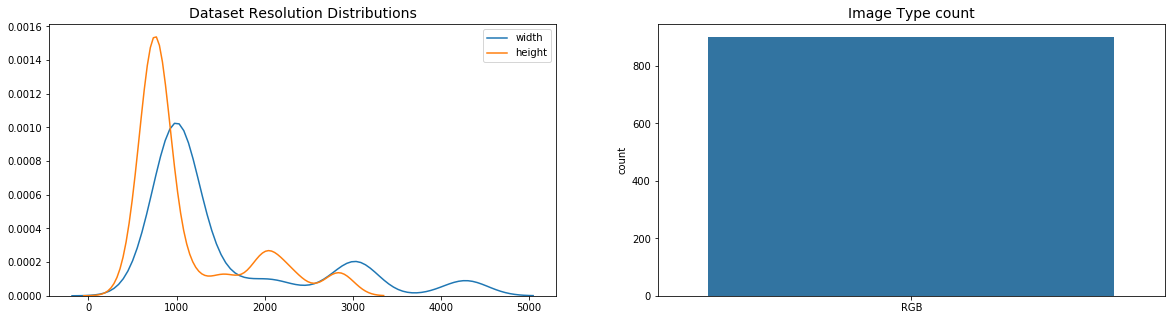

In [8]:
#plot the information from our images for visual analysis 
fig = plt.figure(figsize=(20,5))

#subplot #1 is the KDE distribution of our image data resolutions 
fig.add_subplot(121)
plt.title('Dataset Resolution Distributions', fontsize=14)
ax = sns.kdeplot(image_info_df.width)
ay = sns.kdeplot(image_info_df.height)

#subplot #2 is a count of type of files example RGB, GRB 
fig.add_subplot(122)
plt.title('Image Type count', fontsize=14)
sns.countplot(data=image_info_df,x=img_type,)

plt.show()

##### Apply  preprocessing with Gaussian Filter and Scaling to standard image size 256x256 + Apply Histogram of Graident HOG 

F:\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: rgb2grey is deprecated. It will be removed in version 0.19.Please use rgb2gray instead.


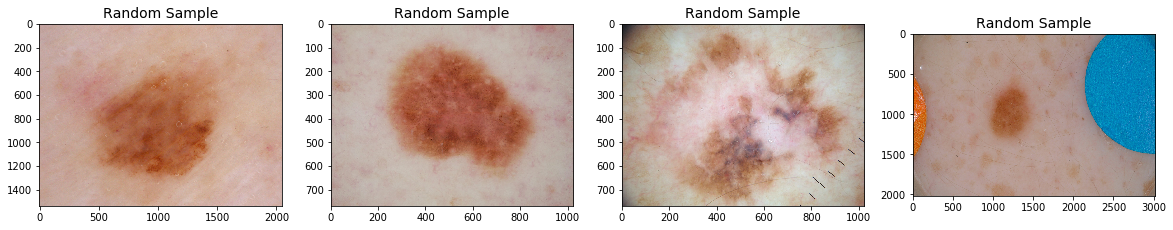

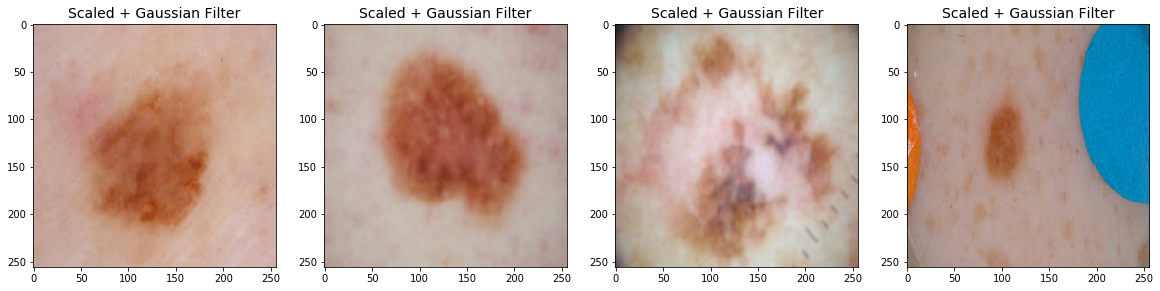

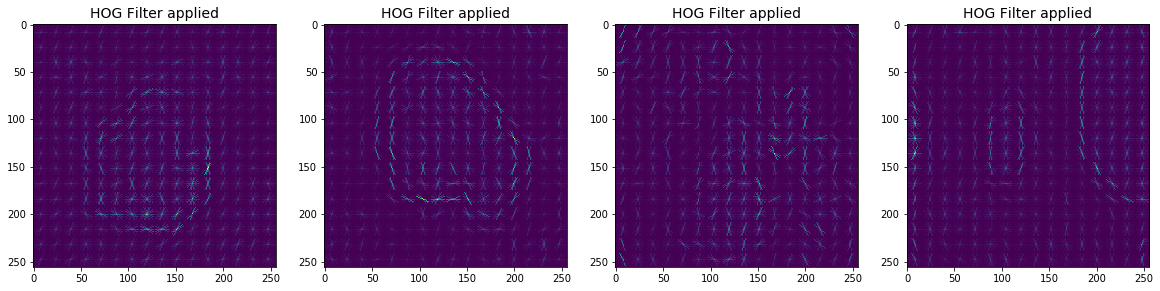

In [9]:
#Check some random images from Raw dataset
raw_data_path = 'C:\\Users\\Rob Hess\\Desktop\\testset\\svm\\mdata'
os.chdir(raw_data_path)

img_list=[]
img_name=[]
for f in sample(dirs,4):
    img = Image.open(f)
    img_array =np.array(img)
    img_list.append(img_array)
    img_name.append(f)
    
    
#Show the scaled version of the random images + Guassian Filter
raw_data_path = 'C:\\Users\\Rob Hess\\Desktop\\testset\\svm\\balanced'
os.chdir(raw_data_path)
img_list2=[]
for f in img_name:
    img = Image.open(f)
    img_array2 =np.array(img)
    img_list2.append(img_array2)
    

#extract HOG features https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients
img_list3=[]
for f in img_list2:
    img_grey= rgb2grey(f)
    hog_feature, hog_image = hog(img_grey, visualize=True, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    img_list3.append(hog_image)
    
    
#plot the information from our images
fig = plt.figure(figsize=(20,5))

fig.add_subplot(141)
plt.title('Random Sample', fontsize=14)
plt.imshow(img_list[0])

fig.add_subplot(142)
plt.title('Random Sample', fontsize=14)
plt.imshow(img_list[1])

fig.add_subplot(143)
plt.title('Random Sample', fontsize=14)
plt.imshow(img_list[2])

fig.add_subplot(144)
plt.title('Random Sample', fontsize=14)
plt.imshow(img_list[3])

plt.show()

#plot the information from our images
fig = plt.figure(figsize=(20,5))

fig.add_subplot(141)
plt.title('Scaled + Gaussian Filter', fontsize=14)
plt.imshow(img_list2[0])


fig.add_subplot(142)
plt.title('Scaled + Gaussian Filter', fontsize=14)
plt.imshow(img_list2[1])

fig.add_subplot(143)
plt.title('Scaled + Gaussian Filter', fontsize=14)
plt.imshow(img_list2[2])

fig.add_subplot(144)
plt.title('Scaled + Gaussian Filter', fontsize=14)
plt.imshow(img_list2[3])

#plot the information from our images
fig = plt.figure(figsize=(20,5))

fig.add_subplot(141)
plt.title('HOG Filter applied', fontsize=14)
plt.imshow(img_list3[0])

fig.add_subplot(142)
plt.title('HOG Filter applied', fontsize=14)
plt.imshow(img_list3[1])

fig.add_subplot(143)
plt.title('HOG Filter applied', fontsize=14)
plt.imshow(img_list3[2])

fig.add_subplot(144)
plt.title('HOG Filter applied', fontsize=14)
plt.imshow(img_list3[3])



plt.show()

In [10]:
""" 
This resize function is used to Scale all Images to 256x256 and applying GuassianBlur to 
reduce sharp features like Hair and other image Noise

"""
# path = "Source Path"
# dirs = os.listdir( path )
# dest = "dest Path"

def resize():
    for item in dirs:
        im = Image.open(path+item)
        im2 = im.filter(ImageFilter.GaussianBlur(radius = 5)) 
        imResize = im2.resize((256,256), Image.ANTIALIAS)
        imResize.save(dest +  item  , 'JPEG', quality=90) 
        
#resize()

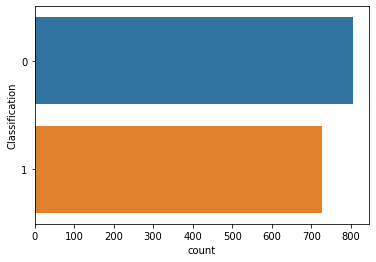

In [11]:
#checking dataset Class balance
sns.countplot(y='Classification', data=labels);

In [14]:
labels.Classification.value_counts()

0    807
1    727
Name: Classification, dtype: int64

###### Stage 3: Feature Engineering for SVM/PCA Model

In [15]:
#creating a function to grab "filename" from labels Dataframe/csv and "load image" into "numpy array" and return it
def get_image_file(row_id, root="."):
    """
    using image name from labels data
    load it from root path into a numpy array and return it.
    """
    filename = "{}.jpg".format(row_id)
    file_path = os.path.join(root, filename)
    img = Image.open(file_path)
    return np.array(img)

In [16]:
# Generating a feature map from color image pixels + adding HOG features to give the SVM model some idea of shape
def make_feature_map(img):
    # flatten three channel color image
    color_features = img.flatten()
    # convert image to greyscale to extract HOG features
    grey_image = rgb2grey(img)
    # get HOG features from greyscale image 
    hog_features = hog(grey_image, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    # combine color and hog features into a single array
    #we are adding color image features + Hog 
    flat_features = np.hstack((color_features, hog_features))
    return flat_features

In [17]:
cd C:\\Users\\Rob Hess\\Desktop\\testset\\svm\\balanced

C:\Users\Rob Hess\Desktop\testset


In [18]:
def create_feature_matrix(label_dataframe):
    features_list = []
    
    for img_id in label_dataframe.index:
        # load image
        img = get_image_file(img_id)
        # get features for image
        image_features = make_feature_map(img)
        features_list.append(image_features)
        
    # convert list of arrays into a matrix
    feature_matrix = np.array(features_list)
    return feature_matrix

# run create_feature_matrix on our dataframe of images
feature_matrix = create_feature_matrix(labels)


F:\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: rgb2grey is deprecated. It will be removed in version 0.19.Please use rgb2gray instead.
  


In [19]:
# get shape of feature matrix before PCA 
print('Feature matrix shape is: ', feature_matrix.shape)

# define standard scaler to scale our data before PCA is applied
ss = StandardScaler()

# run this on our feature matrix
cancer_stand = ss.fit_transform(feature_matrix)

''' 
Typically, we want the explained variance to 
be between 95–99%. 
we can try .95 and .99 componets for PCA

'''
pca = PCA(n_components= 0.95)
#pca = PCA(n_components= 0.99)

# use fit_transform to run PCA on our standardized matrix
cancer_pca = pca.fit_transform(cancer_stand)

# look at new shape after PCA
print('PCA matrix shape is: ', cancer_pca.shape)

Feature matrix shape is:  (1534, 212484)
PCA matrix shape is:  (1534, 273)


In [20]:
#checking what the PCA data looks like out of interest 
dftest = pd.DataFrame(cancer_pca)
dftest.head()

,0,1,2,3,4,5,6,7,8,9,...,263,264,265,266,267,268,269,270,271,272
0,-98.962637,-151.780709,-14.697818,-40.573013,12.978034,-26.073924,59.769766,-86.601200,15.873724,3.724267,...,-15.061067,0.793158,0.481314,-1.816410,-3.237991,-2.323870,0.503141,-8.346243,-1.358252,6.708528
1,-329.602629,-58.866157,-125.964188,8.771752,-70.513617,-75.760270,33.493709,47.941492,116.356466,9.889735,...,0.255853,-7.671637,0.629795,-5.647619,-1.485679,0.919189,-2.078867,1.648941,-0.997232,-0.744455
2,-488.823674,-162.676826,-92.951316,50.566516,-71.672333,-56.192594,55.589780,-0.042277,89.322980,27.483371,...,-5.608205,-8.806443,1.081776,1.601827,1.145143,3.822695,-4.015141,0.409057,-6.453508,0.931263
3,-18.812603,251.816001,-12.020715,-16.412767,-38.011343,26.755788,-32.319715,-75.239754,-1.691269,-104.279411,...,-0.912913,0.044650,-2.023912,10.963764,-0.424421,6.430094,-3.533549,2.228228,0.534495,6.234606
4,55.782621,-152.289815,-38.120803,-29.152333,-24.247985,5.715247,-7.563582,14.866196,57.509730,-18.218873,...,0.618712,2.688992,-2.061180,-2.797470,-9.691157,-1.911411,2.452973,-1.313398,-5.589968,-5.626377


In [21]:
# Split into Train and Test 
X = pd.DataFrame(cancer_pca)
y = pd.Series(labels.Classification.values)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.3,
                                                    random_state=1234123 )

#look at the distrubution of labels in the train set
#pd.Series(y_train).value_counts()

In [22]:
# define support vector classifier

svm = SVC(kernel='rbf', probability=True, random_state=42, C=1)
#svm = SVC(kernel='linear', probability=True, random_state=42)
#gamma=0.000001 made test/train closer but lower 80/79
#{'C': 0.01, 'gamma': 1, 'kernel': 'poly'}

# fit model
svm.fit(X_train, y_train)


SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [23]:
#using a confusion metrics fuctions to look at our results
#reference https://github.com/DTrimarchi10/confusion_matrix
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [24]:
# generate predictions
y_pred = svm.predict(X_test)
y_pred_train = svm.predict(X_train)

# calculate accuracy
training_accuracy = accuracy_score(y_train, y_pred_train)
accuracy = accuracy_score(y_test, y_pred)

print('Model test accuracy is: ', accuracy)
print('Model train accuracy is: ', training_accuracy)


Model test accuracy is:  0.841648590021692
Model train accuracy is:  0.8928238583410997


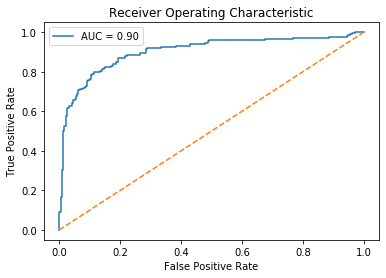

In [26]:
# predict probabilities for X_test using predict_proba
probabilities = svm.predict_proba(X_test)

# select the probabilities for label 1.0
y_proba = probabilities[:, 1]

# calculate false positive rate and true positive rate at different thresholds
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba, pos_label=1)

# calculate AUC
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
# plot the false positive rate on the x axis and the true positive rate on the y axis
roc_plot = plt.plot(false_positive_rate,
                    true_positive_rate,
                    label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');

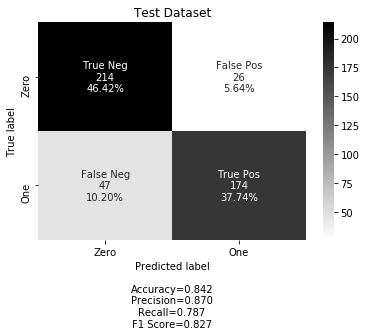

In [27]:
#check confusion matrix for test data

cf_matrix_test=confusion_matrix(y_test, y_pred)
# print(confusion_matrix(y_test, y_pred))
# print(f1_score(y_test, y_pred, average='micro')) 
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']

make_confusion_matrix(cf_matrix_test, 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary', title='Test Dataset')

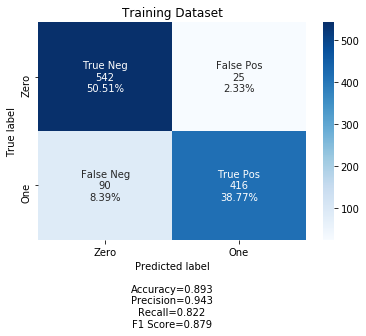

In [28]:
#check confusion matrix for training data

cf_matrix_train=confusion_matrix(y_train, y_pred_train)
# print(confusion_matrix(y_test, y_pred))
# print(f1_score(y_test, y_pred, average='micro')) 
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix_train, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues', title='Training Dataset')

In [115]:
#saving the Model 
#C:\Users\Rob Hess\Desktop\testset\svm

## save the model to disk
filename = 'finalized_model_v1.sav'
joblib.dump(svm, filename)


#save pca weights
pk.dump(pca, open("pca_v1.pkl","wb"))

#Save Scaler file std_scaler.bin and save the sklearn model.
dump(ss, 'std_scaler_v1.bin', compress=True)

#To read the model later use load
# ss=load('std_scaler.bin')

# some time later...
# load the model from disk
#loaded_model = joblib.load(filename)
#result = loaded_model.score(X_test, Y_test)
#print(result)

['std_scaler_v1.bin']

In [116]:
pwd

'C:\\Users\\Rob Hess\\Desktop\\testset\\svm\\mdata'

In [29]:
sensitivity1 = cf_matrix_test[0,0]/(cf_matrix_test[0,0]+cf_matrix_test[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cf_matrix_test[1,1]/(cf_matrix_test[1,0]+cf_matrix_test[1,1])
print('Specificity : ', specificity1)

Sensitivity :  0.8916666666666667
Specificity :  0.7873303167420814
